In [2]:
from intake import open_catalog
import numpy as np
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cmocean
from altimetry_tools import filterSpec, filterSpec1
import warnings 
warnings.filterwarnings('ignore')

# pull AVISO ugos, vgos from pangeo
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
# AVISO on 0.25 degree grid 

In [3]:
ds['ugos']

<xarray.DataArray 'ugos' (time: 8901, latitude: 720, longitude: 1440)>
dask.array<xarray-ugos, shape=(8901, 720, 1440), dtype=float64, chunksize=(5, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
    crs        int32 ...
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Attributes:
    grid_mapping:   crs
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s

In [5]:
ds['ugos'][1].isel(longitude=lon_in, latitude=lat_in)

<xarray.DataArray 'ugos' (latitude: 100, longitude: 120)>
dask.array<getitem, shape=(100, 120), dtype=float64, chunksize=(100, 120), chunktype=numpy.ndarray>
Coordinates:
    crs        int32 ...
  * latitude   (latitude) float32 30.12 30.38 30.62 30.88 ... 54.38 54.62 54.88
  * longitude  (longitude) float32 300.1 300.4 300.6 300.9 ... 329.4 329.6 329.9
    time       datetime64[ns] 1993-01-02
Attributes:
    grid_mapping:   crs
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s

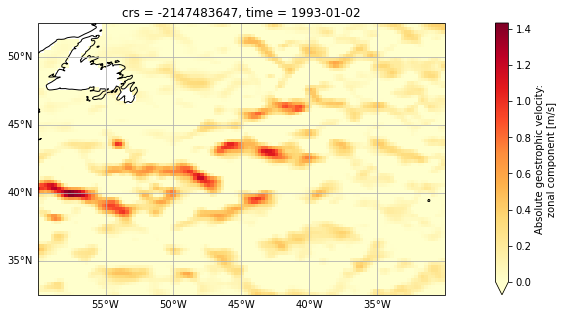

In [4]:
# sample plot of data 
lon_in = np.where((ds['longitude'] > 300) & (ds['longitude'] < 330))[0]
lat_in = np.where((ds['latitude'] > 30) & (ds['latitude'] < 55))[0]
fig,axs = plt.subplots(1,1,figsize=(18,5),subplot_kw={'projection':ccrs.PlateCarree()})
ds['ugos'][1].isel(longitude=lon_in, latitude=lat_in).plot(ax=axs,vmin=0,cmap='YlOrRd',transform=ccrs.PlateCarree())

axs.coastlines()
axs.set_extent([300, 330, 32.5, 52.5], crs=ccrs.PlateCarree())
gl = axs.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([35, 40, 45, 50])

In [3]:
# function Ian helped construct, will filter to: 
# -- constant factor (0.25->1) 
# -- fixed filter scale (relative to smallest grid step in data)
def Laplacian2D(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field. Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (x, y) whose Laplacian is computed
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, size size as 2nd dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Nx = np.size(field,0)
    Ny = np.size(field,1) # I suppose these could be inputs
    notLand = 1 - landMask
    # first compute Laplacian in y direction. "Right" is north and "Left" is south for this block
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxRight[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    fluxLeft = np.zeros((Nx,Ny))
    fluxLeft[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxLeft[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    OUT = (1/(dy**2))*(fluxRight - fluxLeft)
    # Now compute Laplacian in x direction and add it back in
    fluxRight = 0*fluxRight # re-set to zero just to be safe
    fluxLeft = 0*fluxLeft # re-set to zero just to be safe
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    OUT = OUT + (1/(dx**2))*(fluxRight - fluxLeft)
    return OUT*notLand

In [4]:
def Laplacian2D_FV(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field, using a finite volume discretization. 
    Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (y, x) whose Laplacian is computed; note: (y,x) is order of dims in NW2 output 
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, same size as 1st dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Ny = np.size(field,0)
    Nx = np.size(field,1)
    notLand = 1 - landMask
    field = np.nan_to_num(field) # set all NaN's to zero
    ## transpose all fields so that numpy broadcasting coorperates (when multiplying with dx)
    field = np.transpose(field)
    notLand = np.transpose(notLand)
    ## Approximate x derivatives on left and right cell boundaries
    fluxLeft = np.zeros((Nx,Ny))
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:])/dx # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:])/dx # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:])/dx # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:])/dx # Periodic unless there's land in the way
    # multiply by length of cell boundary
    fluxLeft = fluxLeft*dy 
    fluxRight = fluxRight*dy
    OUT = fluxRight - fluxLeft
    # Approximate y derivatives on south and north cell boundaries
    fluxNorth = np.zeros((Nx,Ny))
    fluxSouth = np.zeros((Nx,Ny))
    fluxNorth[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1])/dy # Set flux to zero if on land
    fluxNorth[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1])/dy # Periodic unless there's land in the way
    fluxSouth[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1])/dy # Set flux to zero if on land
    fluxSouth[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1])/dy # Periodic unless there's land in the way
    # multiply by length of cell boundary
    # note: the following 4 lines is where this code makes a difference from above Laplacian2D_FD
    fluxNorth[:,0:Ny-1] = fluxNorth[:,0:Ny-1]*(dx[0:Ny-1]+dx[1:Ny])/2 
    fluxNorth[:,Ny-1] = fluxNorth[:,Ny-1]*(dx[Ny-1]+dx[0])/2 # Periodic unless there's land in the way
    fluxSouth[:,1:Ny] = fluxSouth[:,1:Ny]*(dx[0:Ny-1]+dx[1:Ny])/2 
    # fluxSouth[:,0] = fluxSouth[:,0]*(dx[0]+dx[Nx-1])/2 # Periodic unless there's land in the way
    
    # MY EDIT  
    # print(np.shape(fluxSouth))
    # print(Nx)
    # print(np.shape(dx))
    
    fluxSouth[:,0] = fluxSouth[:,0]*(dx[0]+dx[Ny-1])/2 # Periodic unless there's land in the way (CHANGED dx has dimensions Ny NOT Nx)
    OUT = OUT + (fluxNorth - fluxSouth) 
    
    # divide by cell area
    area = dx*dy
    OUT = notLand * OUT/area
    OUT = np.transpose(OUT) # transpose back
    return OUT

In [12]:
# input field with dimensions [time, lat, lon]
def Filter2d(NL,sL,NB,sB,field,dx,dy):  
    # define land mask based on nan bounds of model domain
    Nx = len(field[1, :])
    Ny = len(field[:, 1])
    landMask = 0*np.random.randint(0,2,(Nx,Ny))
    field_array = np.array(field)
    landMask[np.isnan(np.transpose(field_array))] = 1
    landMask[np.transpose(field_array == 0)] = 1
    landMask = np.transpose(landMask)
    wetMask = 1 - landMask
    
    data_out = np.nan * np.ones(np.shape(field))     
    data = field.copy()
    data = np.nan_to_num(data) 
    data = data * wetMask # Initalize the filtering process
    # print(np.shape(data))
    # print(np.shape(landMask))
    for i in range(NL):
        tempL = Laplacian2D_FV(data, landMask, dx, np.int(dy))        # Laplacian1D(data,landMask,dx)
        data = data + (1/sL[i])*tempL # Update filtered field
    for i in range(NB):
        tempL = Laplacian2D_FV(data, landMask, dx, np.int(dy))        # Laplacian1D(data, landMask, dx)
        tempB = Laplacian2D_FV(tempL, landMask, dx, np.int(dy))       # Laplacian1D(tempL, landMask, dx)
        data = data + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
    data_out[np.where(wetMask > 0)] = data[np.where(wetMask > 0)] 
    # data1[np.where(data1 == 0.0)[0]] = np.nan 
    data_out2 = xr.DataArray(data=data_out, coords=field.coords)
    
    return(data_out2)

Using default N, N = 8 If d>2 or X is not pi then results might not be accurate.
Gaussian, # Laplacian steps: 4; # Biharmonic steps: 2
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Taper, # Laplacian steps: 22; # Biharmonic steps: 2


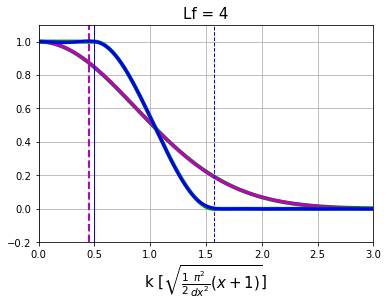

In [21]:
filter_fac = 4
dxMin = 1
Lf_g = filter_fac  # /np.sqrt(6)
Lf_t = filter_fac  # /2
# construct filter 
p, NL_g,sL_g,NB_g,sB_g = filterSpec1(dxMin,Lf_g,d=2,shape="Gaussian",X=np.pi,N=-1,plot_filter=1)
print('Gaussian, # Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))
p, NL_t,sL_t,NB_t,sB_t = filterSpec1(dxMin,Lf_t,d=2,shape="Taper",X=np.pi,N=-1,plot_filter=1)
print('Taper, # Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [8]:
# time indices from which to generate 5-day average
select_index = 8040  # Jan 6 2015
select_index = 6168  # Nov 21 2009 

# test = ds['ugos'][select_index].data
# test = test[None, :, :]
# Nx = len(test[0, 1, :])
# Ny = len(test[0, :, 1])
# landMask = 0*np.random.randint(0,2,(Nx,Ny))
# landMask[np.isnan(np.transpose(test[0, :, :]))] = 1
# landMask[np.transpose(test[0, :, :] == 0)] = 1
# landMask = np.transpose(landMask)

dimensions: 
1440 = lon
720 = lat <br />
-- my laplacian -- 
need 1440 x 720 (dx is a 1D array, same size as 2nd dimension of field) <br />
-- nora's -- 
data should be (y,x), need (720 x 1440) (dx same size as 1st dimension of field)

In [10]:
# cell area
dy0 = 1852*60*(ds['latitude'][2].data - ds['latitude'][1].data)
dx0 = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data)
area = dy0*np.tile(dx0[:, None], (1, len(ds['longitude'])))

In [22]:
# FILTER 
# filter total KE (square of velocity)
dx = np.ones(len(ds['latitude']))
dy = 1
ke_og = 0.5*(ds['ugos'][select_index:select_index+6].mean(axis=0)**2 + ds['vgos'][select_index:select_index+6].mean(axis=0)**2)
%time ke_G = Filter2d(NL_g, sL_g, NB_g, sB_g, area*ke_og, dx, dy)
%time ke_S = Filter2d(NL_t, sL_t, NB_t, sB_t, area*ke_og, dx, dy)
ke_G = ke_G/area
ke_S = ke_S/area

CPU times: user 2.93 s, sys: 421 ms, total: 3.35 s
Wall time: 2.54 s
CPU times: user 4.61 s, sys: 378 ms, total: 4.99 s
Wall time: 4.04 s


In [23]:
# FILTER
# dy = 1852*60*(ds['latitude'][2].data - ds['latitude'][1].data)
# dx = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data)
dx = np.ones(len(ds['latitude']))
dy = 1
# filter AVISO 5 day average
%time u_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, area*ds['ugos'][select_index:select_index+6].mean(axis=0), dx, dy)
%time v_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, area*ds['vgos'][select_index:select_index+6].mean(axis=0), dx, dy)
%time u_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, area*ds['ugos'][select_index:select_index+6].mean(axis=0), dx, dy)
%time v_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, area*ds['vgos'][select_index:select_index+6].mean(axis=0), dx, dy)
u_filtG = u_filtG/area
v_filtG = v_filtG/area
u_filtS = u_filtS/area
v_filtS = v_filtS/area

CPU times: user 2.15 s, sys: 194 ms, total: 2.34 s
Wall time: 2.13 s
CPU times: user 2.5 s, sys: 275 ms, total: 2.77 s
Wall time: 2.44 s
CPU times: user 4.35 s, sys: 255 ms, total: 4.6 s
Wall time: 4.34 s
CPU times: user 4.3 s, sys: 275 ms, total: 4.58 s
Wall time: 4.3 s


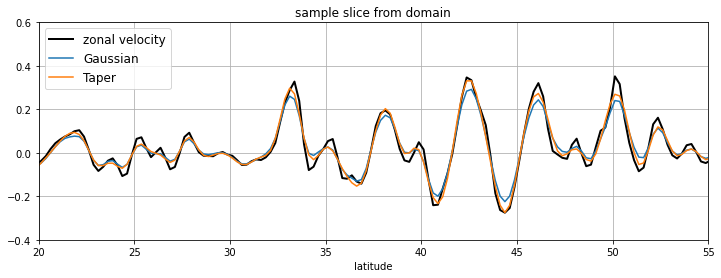

In [24]:
# sample meridional section to show effect of filtering velocity 
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ds['latitude'].data, ds['ugos'][select_index][:, 1300], label='zonal velocity', linewidth=2, color='k')
ax.plot(ds['latitude'].data, u_filtG[:, 1300], label='Gaussian')
ax.plot(ds['latitude'].data, u_filtS[:, 1300], label='Taper')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12, loc='upper left')
ax.set_title('sample slice from domain')
ax.set_xlabel('latitude')
ax.set_xlim([20,55])
ax.set_ylim([-0.4, 0.6])
ax.grid()
plt.show()

In [16]:
# -- load coastlines if not using cartopy 
# x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/landmask_01.nc') 
# land_cmap = plt.cm.get_cmap('viridis')
# land_cmap.set_over('#D3D3D3') #FFDEAD

In [25]:
# calculate KE, MKE, EKE 
ke = 0.5*(ds['ugos'][select_index:select_index+6].mean(axis=0)**2 + ds['vgos'][select_index:select_index+6].mean(axis=0)**2)
ke_filtG = 0.5*(u_filtG**2 + v_filtG**2)
ke_filtS = 0.5*(u_filtS**2 + v_filtS**2)

eke_G = ke_G - 0.5*(u_filtG**2 + v_filtG**2)
eke_S = ke_S - 0.5*(u_filtS**2 + v_filtS**2)

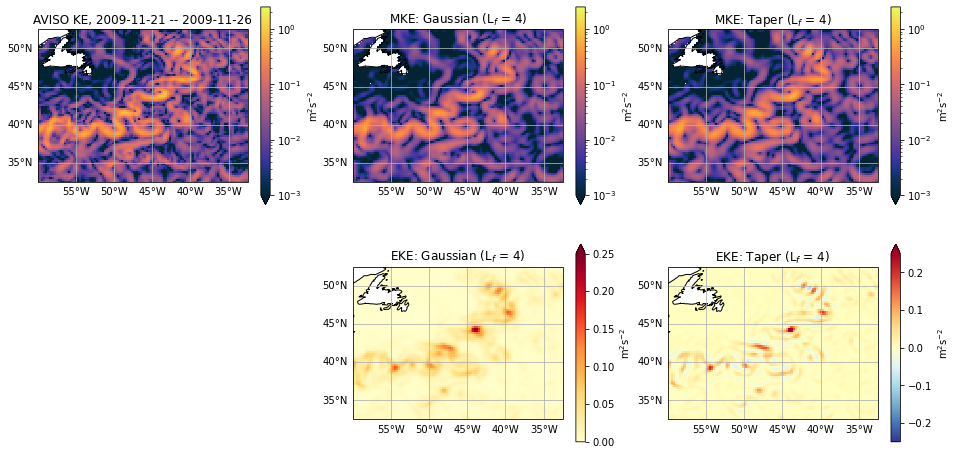

In [36]:
# lat-lon region to plot  
lon_in = np.where((ds['longitude'] > 300) & (ds['longitude'] < 327.5))[0]
lat_in = np.where((ds['latitude'] > 32.5) & (ds['latitude'] < 52.5))[0]
# FIGURE 
fig,axs = plt.subplots(2,3,figsize=(16,8),subplot_kw={'projection':ccrs.PlateCarree()})
this_time = str(ds['time'][select_index].data)
this_time2 = str(ds['time'][select_index+5].data)
cmap_ke = cmocean.cm.thermal
ke_lims = [0.001, 2.5]

# Total KE 
ke.isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[0,0],norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]),\
                                                cmap=cmap_ke,transform=ccrs.PlateCarree(), cbar_kwargs={"label": 'm$^2$s$^{-2}$'})
axs[0,0].set_title('AVISO KE, ' + this_time[0:10] + ' -- ' + this_time2[0:10], fontsize=12)
# MKE Gaussian
ke_filtG.isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[0,1],norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]),\
                                                      cmap=cmap_ke,transform=ccrs.PlateCarree(), cbar_kwargs={"label": 'm$^2$s$^{-2}$'})
axs[0,1].set_title('MKE: Gaussian (L$_{f}$ = ' + str(Lf_t) + ')')
# MKE Taper 
ke_filtS.isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[0,2],norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]),\
                                                cmap=cmap_ke,transform=ccrs.PlateCarree(), cbar_kwargs={"label": 'm$^2$s$^{-2}$'})
axs[0,2].set_title('MKE: Taper (L$_{f}$ = ' + str(Lf_t) + ')')
# EKE Gaussian
eke_G.isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[1,1],vmin=0, vmax=0.25,cmap='YlOrRd',transform=ccrs.PlateCarree(), \
                                                   cbar_kwargs={"label": 'm$^2$s$^{-2}$'})
axs[1,1].set_title('EKE: Gaussian (L$_{f}$ = ' + str(Lf_t) + ')')
# EKE Taper
eke_S.isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[1,2],vmin=-0.25, vmax=0.25,cmap='RdYlBu_r',transform=ccrs.PlateCarree(), \
                                                   cbar_kwargs={"label": 'm$^2$s$^{-2}$'})
axs[1,2].set_title('EKE: Taper (L$_{f}$ = ' + str(Lf_t) + ')')

axs2 = [axs[0,0], axs[0,1], axs[0,2], axs[1,1], axs[1,2]]
for ax in axs2:
    ax.coastlines()
    ax.set_extent([300, 327.5, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.title = False
    gl.ylocator = mticker.FixedLocator([35, 40, 45, 50])

fig.delaxes(axs[1,0])
# plt.show()
fig.savefig('aviso_ke_mke_eke.jpg', dpi=500)

In [109]:
# option to save as netcdf 
file_out = 'aviso_ke.nc'
save_nc = 0  # toggle to 1 to save 
if save_nc > 0:
    OL_out = netcdf.netcdf_file(file_out, 'w')
    OL_out.title = 'aviso surface geostrophic velocity'
    # OL_out.subtitle = 'center lat,lon = ' + str(lat_0) + ',' + str(lon_0)
    # create dimenision
    x_dim = OL_out.createDimension('lon_dim', len(ds['longitude']))
    y_dim = OL_out.createDimension('lat_dim', len(ds['latitude']))
    # assign variables
    x_out = OL_out.createVariable('longitude', np.float64, ('lon_dim',)) # np.float64,
    x_out[:] = ds['longitude']
    y_out = OL_out.createVariable('latitude', np.float64, ('lat_dim',))
    y_out[:] = ds['latitude'] 
    area_out = OL_out.createVariable('area', np.float64, ('lat_dim', 'lon_dim'))
    area_out[:] = area
    u_out = OL_out.createVariable('ugos', np.float64, ('lat_dim', 'lon_dim'))
    u_out[:] = np.nanmean(ds['ugos'][select_index:select_index+6].data, axis=0)
    v_out = OL_out.createVariable('vgos', np.float64, ('lat_dim', 'lon_dim'))
    v_out[:] = np.nanmean(ds['vgos'][select_index:select_index+6].data, axis=0)
    ke_out = OL_out.createVariable('ke', np.float64, ('lat_dim', 'lon_dim'))
    ke_out[:] = ke
    ke_g_out = OL_out.createVariable('ke_gaussian', np.float64, ('lat_dim', 'lon_dim'))
    ke_g_out[:] = ke_filtG
    ke_s_out = OL_out.createVariable('ke_taper', np.float64, ('lat_dim', 'lon_dim'))
    ke_s_out[:] = ke_filtS  
    OL_out.close() 